The following cell ensures that the Python files in the `project_dir/code/` directory can be correctly imported by this notebook

In [26]:
import sys
import os
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Add the project's `code` directory to the Python path
notebooks_dir = os.getcwd()
project_dir = os.path.dirname(notebooks_dir)
code_dir = os.path.join(project_dir, 'code')  
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

from my_utils import dict_from_disk, load_image_as_tensor
from cross_attention_dataset import CrossAttentionDataset
from probing_models import LinearProbe
from visualisation_utils import plot_masks_grid

from sklearn.model_selection import train_test_split
import numpy as np

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

### Load cross-attention maps from disk

In [3]:
DATA_PATH = Path(r"C:\Users\aapolina\CODE\diffusion_segmentation\DATA\data\data\ECSSD_resized")

In [4]:
# Set the path to the directory containing the cross-attention maps
FEATURE_DIR = Path(f"{DATA_PATH}/features/cross_attn")

# Filter files in directory for the cross-attention maps
cross_attn_filenames = sorted([f for f in FEATURE_DIR.glob("*.h5") if f.stem.endswith("_cross")])

# Load the cross-attention maps
cross_attn_maps = [dict_from_disk(str(f)) for f in tqdm(cross_attn_filenames)]

100%|██████████| 1000/1000 [00:17<00:00, 58.16it/s]


In [5]:
GT_DIR = Path(f"{DATA_PATH}/gt")

# Load the ground truth masks for the cross-attention maps as (64, 64) tensors
base_names = map(lambda path: path.stem, cross_attn_filenames)
gt_paths = sorted([GT_DIR / f"{base_name.split('_')[0]}.png" for base_name in base_names])
gt_segmentations = [load_image_as_tensor(path, True) for path in gt_paths]

### Create a dataset and data loader from cross-attention maps

In [6]:
cross_attn_maps_train, cross_attn_maps_valid, gt_segmentations_train, gt_segmentations_valid = train_test_split(cross_attn_maps, gt_segmentations, test_size=0.2, random_state=42)

In [7]:
dataset = CrossAttentionDataset(cross_attn_maps, gt_segmentations)

dataset_train = CrossAttentionDataset(cross_attn_maps_train, gt_segmentations_train)
data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)

dataset_valid = CrossAttentionDataset(cross_attn_maps_valid, gt_segmentations_valid)
data_loader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=True)

### Train model

In [27]:
model = LinearProbe(n_timesteps=len(dataset_train.timesteps)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

In [28]:
def evaluate_training(model,loader, criterion):
    loss_valid = []
    with torch.no_grad():
        
        for  cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in loader:
            cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)
            output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64).unsqueeze(0)


            loss = criterion(output, gt)
            loss_valid.append(loss.item())

    return np.mean(loss_valid)

In [29]:
losses_train = []
losses_valid = []

for epoch in range(10):
    loss_epoch_train=[]

    with tqdm(data_loader_train, desc=f"Epoch {epoch}") as tepoch:
        for cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in tepoch:
            cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64).unsqueeze(0)
            loss = criterion(output, gt)
            loss_epoch_train.append(loss.item())

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update the progress bar description
            tepoch.set_description(f"Epoch {epoch}")# Loss: {loss.item():.4f}")
        
    loss_epoch_valid = evaluate_training(model, data_loader_valid, criterion)
    loss_epoch_train = np.mean(loss_epoch_train)
    losses_train.append(loss_epoch_train)
    losses_valid.append(loss_epoch_valid)   
        
    print(f"Epoch {epoch} \n Train Loss: {loss_epoch_train:.4f} \n Valid Loss: {loss_epoch_valid:.4f}")
    

Epoch 0: 100%|██████████| 800/800 [00:07<00:00, 111.82it/s]


Epoch 0 
 Train Loss: 80.2330 
 Valid Loss: 80.0019


Epoch 1: 100%|██████████| 800/800 [00:07<00:00, 112.72it/s]


Epoch 1 
 Train Loss: 80.0912 
 Valid Loss: 79.9809


Epoch 2: 100%|██████████| 800/800 [00:06<00:00, 116.08it/s]


Epoch 2 
 Train Loss: 80.0788 
 Valid Loss: 79.9653


Epoch 3: 100%|██████████| 800/800 [00:07<00:00, 113.23it/s]


Epoch 3 
 Train Loss: 80.0601 
 Valid Loss: 79.9510


Epoch 4: 100%|██████████| 800/800 [00:07<00:00, 112.95it/s]


Epoch 4 
 Train Loss: 80.0531 
 Valid Loss: 79.9475


Epoch 5: 100%|██████████| 800/800 [00:07<00:00, 112.22it/s]


Epoch 5 
 Train Loss: 80.0506 
 Valid Loss: 79.9460


Epoch 6: 100%|██████████| 800/800 [00:07<00:00, 110.99it/s]


Epoch 6 
 Train Loss: 80.0495 
 Valid Loss: 79.9453


Epoch 7: 100%|██████████| 800/800 [00:07<00:00, 110.54it/s]


Epoch 7 
 Train Loss: 80.0488 
 Valid Loss: 79.9448


Epoch 8: 100%|██████████| 800/800 [00:07<00:00, 109.98it/s]


Epoch 8 
 Train Loss: 80.0484 
 Valid Loss: 79.9445


Epoch 9: 100%|██████████| 800/800 [00:07<00:00, 106.18it/s]


Epoch 9 
 Train Loss: 80.0482 
 Valid Loss: 79.9443


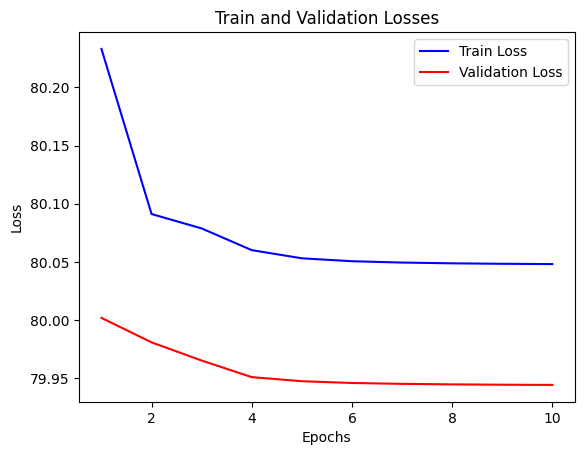

In [30]:
import matplotlib.pyplot as plt

epochs = range(1, len(losses_train) + 1)

plt.plot(epochs, losses_train, 'b', label='Train Loss')
plt.plot(epochs, losses_valid, 'r', label='Validation Loss')
plt.title('Train and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Show the cross-attention maps

In [31]:
model.to(DEVICE)

LinearProbe(
  (sigmoid): Sigmoid()
)

In [44]:
idx = 111

img = load_image_as_tensor(gt_paths[idx].parent.parent / "img" / (gt_paths[idx].stem + ".jpg"))
gt = load_image_as_tensor(gt_paths[idx], True)

with torch.no_grad():
    cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, _ = dataset[idx]
    output = model(cross_attn_8.to(DEVICE), cross_attn_16.to(DEVICE),cross_attn_32.to(DEVICE), cross_attn_64.to(DEVICE))
    output = output.squeeze().detach()#.cpu().numpy()

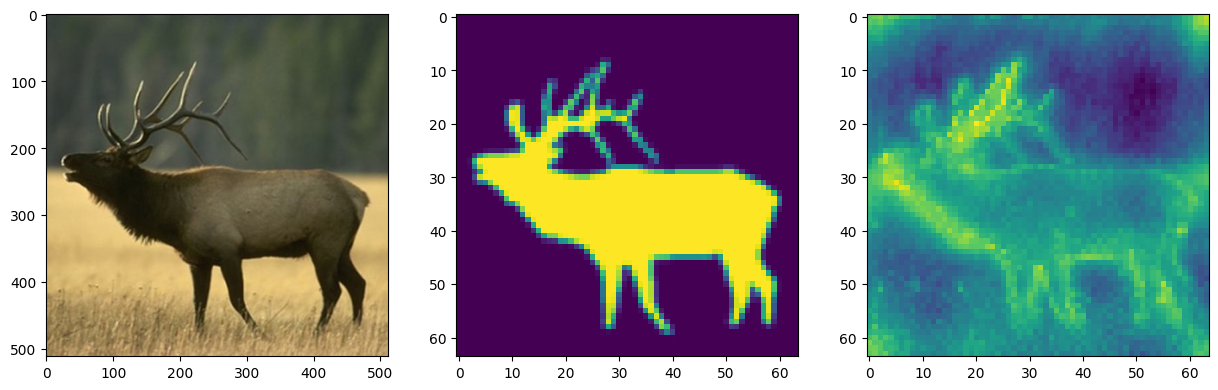

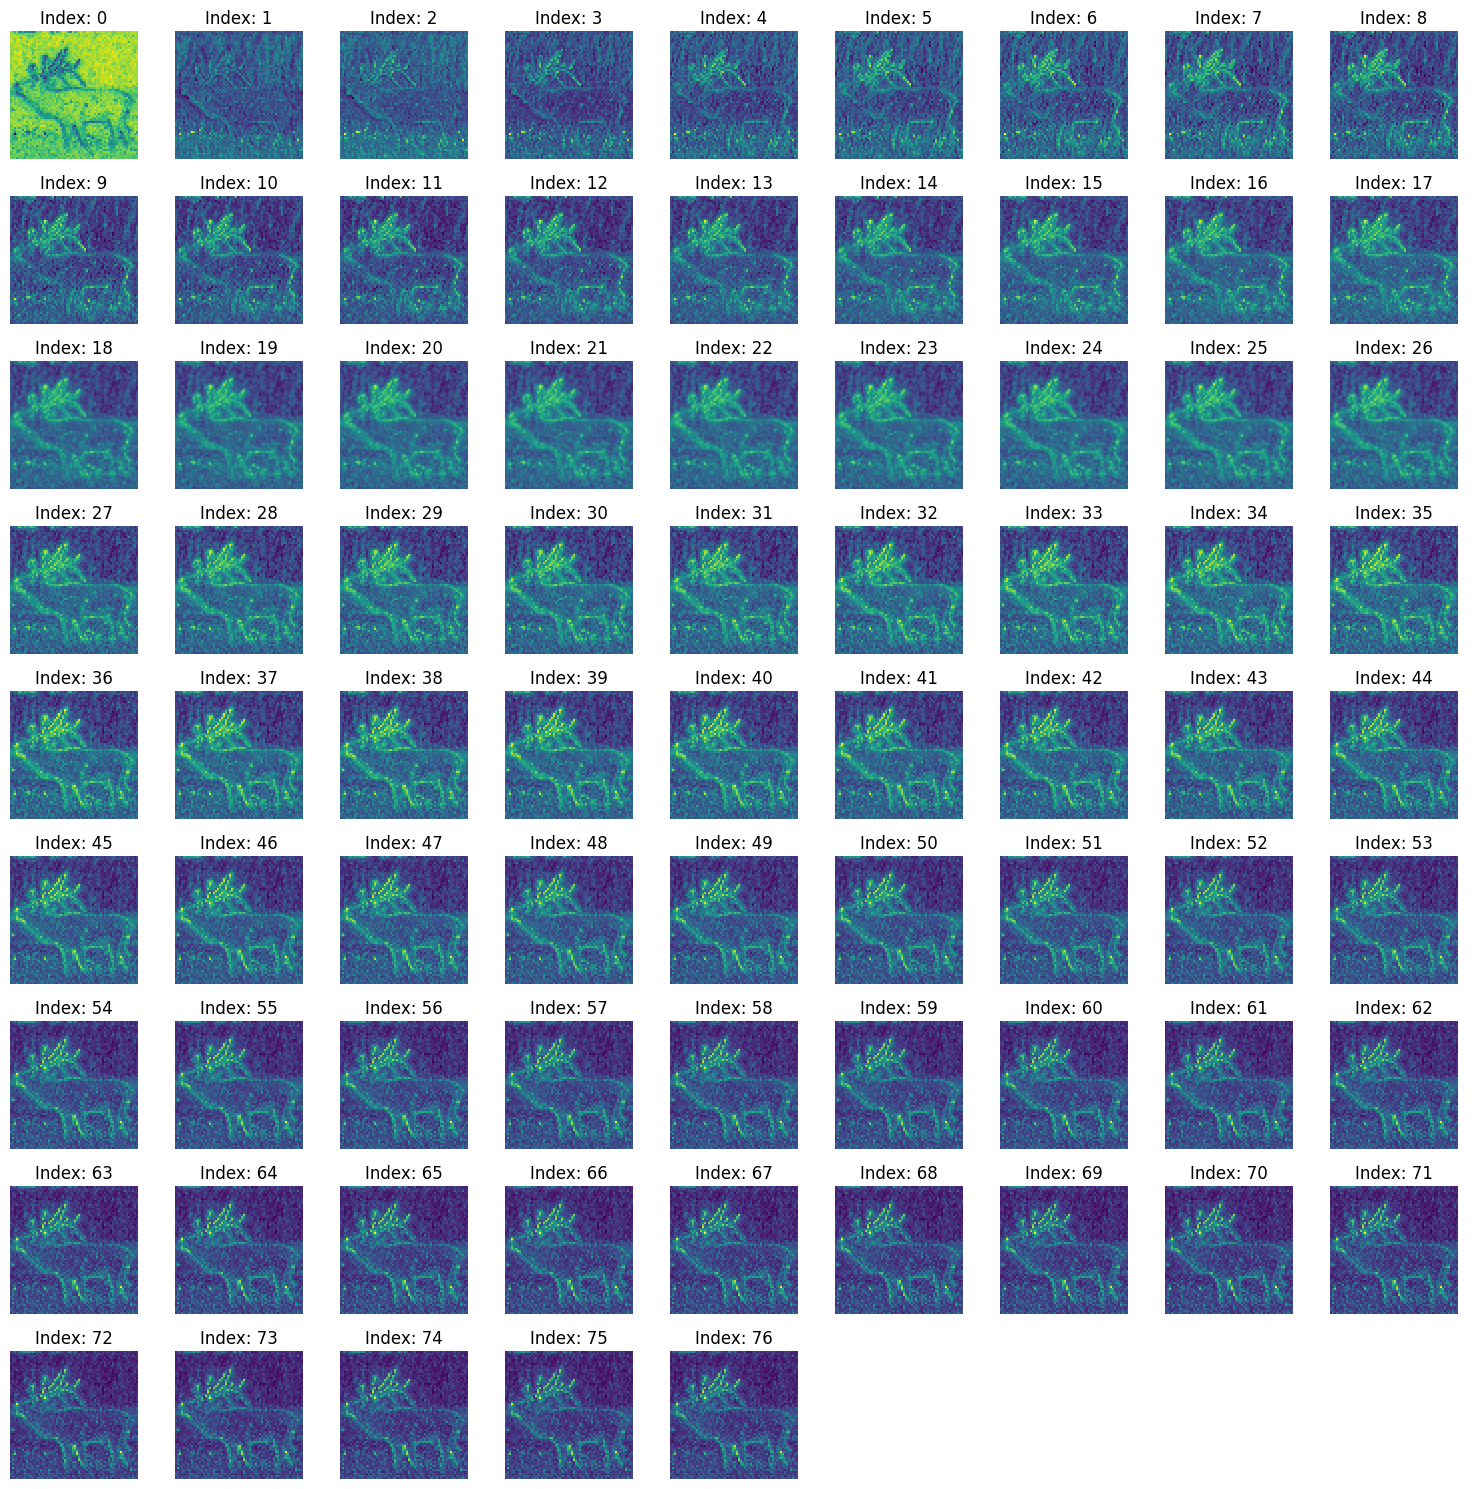

In [45]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

img = img.cpu()
gt = gt.cpu()
output = output.cpu()

axs[0].imshow(img.permute(1, 2, 0))
axs[1].imshow(gt)
axs[2].imshow(output)

plot_masks_grid(cross_attn_64[0])

In [46]:
print(f"Ouput range: [{torch.min(output)}, {torch.max(output)}]")

Ouput range: [0.6091912984848022, 0.7870533466339111]


why are the output values always in range ca. [0.6,0.8]?

In [47]:
print(f"Ouput range: [{torch.min(gt)}, {torch.max(gt)}]")

Ouput range: [0.0, 1.0]
